## Project 1: US Traffic Accidents

### Overview

This project performs a deep-dive diagnostic analysis of large-scale traffic accident data across the United States. Utilizing a dataset of millions of accident records, the study employs Python (Pandas, PySpark) for heavy-duty data processing and Matplotlib/Seaborn for exploratory visualization.

The goal is to transition from descriptive analytics (what happened) to prescriptive insights (what should be done). The final deliverables include a reproducible computational notebook, an interactive Tableau Dashboard for spatial exploration, and a strategic briefing for DOT stakeholders.

### Business Understanding

1. **The Challenge**

    Traffic fatalities and road accidents represent a significant public health crisis and a massive economic burden, costing billions in property damage, healthcare, and lost productivity. The Department of Transportation (DOT) faces the challenge of allocating limited resources—such as highway patrols, infrastructure upgrades, and emergency response teams—across a vast national network. Without data-driven prioritization, interventions are often reactive rather than proactive.

2. **Primary Objective**

    The objective of this analysis is to identify the high-risk variables that contribute to accident frequency and severity. By uncovering hidden patterns in temporal trends, weather impacts, and infrastructure flaws, we aim to provide the DOT with three high-impact, data-driven recommendations to:

    - **Reduce Accident Frequency**: By identifying "hotspots" and high-risk time windows.

    - **Mitigate Severity**: By understanding which environmental or infrastructural factors lead to fatal outcomes versus minor collisions.

    - **Optimize Resource Allocation**: Providing a blueprint for where the DOT should implement safety measures (e.g., improved lighting, signage, or traffic calming).

3. **Key Stakeholders**

    - Department of Transportation (DOT) Executives, Urban Planners & Engineers & Public Safety Officials

### Data Understanding

In [1]:
# Initializing the SparkSession

from pyspark.sql import SparkSession

spark = SparkSession.builder.master('local').appName('Accidents Analysis Project').getOrCreate()

***Note***: This code helps us naviagte to our file directory so that we can access the data.

In [2]:
import os

print("Current Directory:", os.getcwd(), '\n')
print("Files in directory:", os.listdir('./work'))

Current Directory: /home/jovyan 

Files in directory: ['.git', '.gitignore', '.ipynb_checkpoints', 'data', 'icons', 'README.md', 'US_Accidents_Cleaned_Tableau.csv', 'us_traffic_accidents_analysis.ipynb']


In [3]:
spark_df = spark.read.csv('./work/data/US_Accidents_March23.csv', inferSchema=True, header=True) 

In [4]:
# Verifying the data types within the dataset.

spark_df.printSchema()

root
 |-- ID: string (nullable = true)
 |-- Source: string (nullable = true)
 |-- Severity: integer (nullable = true)
 |-- Start_Time: timestamp (nullable = true)
 |-- End_Time: timestamp (nullable = true)
 |-- Start_Lat: double (nullable = true)
 |-- Start_Lng: double (nullable = true)
 |-- End_Lat: double (nullable = true)
 |-- End_Lng: double (nullable = true)
 |-- Distance(mi): double (nullable = true)
 |-- Description: string (nullable = true)
 |-- Street: string (nullable = true)
 |-- City: string (nullable = true)
 |-- County: string (nullable = true)
 |-- State: string (nullable = true)
 |-- Zipcode: string (nullable = true)
 |-- Country: string (nullable = true)
 |-- Timezone: string (nullable = true)
 |-- Airport_Code: string (nullable = true)
 |-- Weather_Timestamp: timestamp (nullable = true)
 |-- Temperature(F): double (nullable = true)
 |-- Wind_Chill(F): double (nullable = true)
 |-- Humidity(%): double (nullable = true)
 |-- Pressure(in): double (nullable = true)
 |-- V

In [5]:
# Counting the total record in the dataset

print(f"Total Accidents in Dataset: {spark_df.count()}")

Total Accidents in Dataset: 7728394


***Note***: The columns below are insignificant for our analysis which is why I've decided to exclude it from our further analysis. Also, some columns have redundant values as it can be described by another column. 

In [6]:
# List of columns that don't add value to the safety analysis. Also, some reduntant columns --to remove.

cols_to_drop = [
    'Source', 'End_Lat', 'End_Lng', 'Description',        
    'Street', 'Country', 'Timezone', 'Airport_Code',
    'Weather_Timestamp', 'Wind_Chill(F)', 'Wind_Direction',        
    'Wind_Speed(mph)', 'Pressure(in)', 'Civil_Twilight',        
    'Nautical_Twilight', 'Astronomical_Twilight', 'Turning_Loop',            
    'Bump', 'Give_Way', 'No_Exit', 'Roundabout'    
]

df_lean = spark_df.drop(*cols_to_drop)
df_lean.printSchema()

root
 |-- ID: string (nullable = true)
 |-- Severity: integer (nullable = true)
 |-- Start_Time: timestamp (nullable = true)
 |-- End_Time: timestamp (nullable = true)
 |-- Start_Lat: double (nullable = true)
 |-- Start_Lng: double (nullable = true)
 |-- Distance(mi): double (nullable = true)
 |-- City: string (nullable = true)
 |-- County: string (nullable = true)
 |-- State: string (nullable = true)
 |-- Zipcode: string (nullable = true)
 |-- Temperature(F): double (nullable = true)
 |-- Humidity(%): double (nullable = true)
 |-- Visibility(mi): double (nullable = true)
 |-- Precipitation(in): double (nullable = true)
 |-- Weather_Condition: string (nullable = true)
 |-- Amenity: boolean (nullable = true)
 |-- Crossing: boolean (nullable = true)
 |-- Junction: boolean (nullable = true)
 |-- Railway: boolean (nullable = true)
 |-- Station: boolean (nullable = true)
 |-- Stop: boolean (nullable = true)
 |-- Traffic_Calming: boolean (nullable = true)
 |-- Traffic_Signal: boolean (nullab

***Note***: This helps us get a quick summary for all our numeric columns.

In [7]:
# Selecting all the numerical columns in our dataset 
num_cols = [col for col, data_type in df_lean.dtypes if data_type in ['int', 'double']]

# General statistics for our numerical columns
df_lean.select(num_cols).summary().show()

+-------+------------------+------------------+------------------+------------------+------------------+------------------+-----------------+--------------------+
|summary|          Severity|         Start_Lat|         Start_Lng|      Distance(mi)|    Temperature(F)|       Humidity(%)|   Visibility(mi)|   Precipitation(in)|
+-------+------------------+------------------+------------------+------------------+------------------+------------------+-----------------+--------------------+
|  count|           7728394|           7728394|           7728394|           7728394|           7564541|           7554250|          7551296|             5524808|
|   mean| 2.212384487643875| 36.20119454946952|-94.70254538794683|0.5618422831523706| 61.66328580940991| 64.83104146672403|9.090376447963413|0.008407209807109432|
| stddev|0.4875313339360398| 5.076079113874013| 17.39175625334916|1.7768106031970923|19.013653291093142|22.820967660113475| 2.68831592141714| 0.11022464885795538|
|    min|             

In [8]:
from pyspark.sql import functions as F

# Counting nulls for every column

null_counts = df_lean.select([F.count(F.when(F.col(c).isNull(), c)).alias(c) for c in df_lean.columns])
null_counts.show()

+---+--------+----------+--------+---------+---------+------------+----+------+-----+-------+--------------+-----------+--------------+-----------------+-----------------+-------+--------+--------+-------+-------+----+---------------+--------------+--------------+
| ID|Severity|Start_Time|End_Time|Start_Lat|Start_Lng|Distance(mi)|City|County|State|Zipcode|Temperature(F)|Humidity(%)|Visibility(mi)|Precipitation(in)|Weather_Condition|Amenity|Crossing|Junction|Railway|Station|Stop|Traffic_Calming|Traffic_Signal|Sunrise_Sunset|
+---+--------+----------+--------+---------+---------+------------+----+------+-----+-------+--------------+-----------+--------------+-----------------+-----------------+-------+--------+--------+-------+-------+----+---------------+--------------+--------------+
|  0|       0|         0|       0|        0|        0|           0| 253|     0|    0|   1915|        163853|     174144|        177098|          2203586|           173459|      0|       0|       0|      0|

### Findings - Report

The above analystical findings reveals the following data findings: 

1. **Missing Values**

    Here, some columns seems to be fully populated like (**Severity** and **Distance(mi)**) while others are missing some values. 

2. **Identifying Outliers**

    Some columns shows extreme values like the max **Temperature(F)** being 207.0, **Distance(mi)** being 140.0, **Visibility(mi)** being 140.0 which are not physically possible. We can look into those values as these values tends to skew our data by a lot.

3. **Distribution Insights**

    From the distribution of our data, we can find that for **Severity**, the mean is 2.21 so, the vast majority of accidents in your dataset are "Level 2" severity. Also, for the **Distance(mi)** column, the discrepency betweeen the mean and the median indicates a highly right-skewed distribution -most accidents are local, but a few massive outliers are pulling the average up.




In [9]:
df_lean.head()

Row(ID='A-1', Severity=3, Start_Time=datetime.datetime(2016, 2, 8, 5, 46), End_Time=datetime.datetime(2016, 2, 8, 11, 0), Start_Lat=39.865147, Start_Lng=-84.058723, Distance(mi)=0.01, City='Dayton', County='Montgomery', State='OH', Zipcode='45424', Temperature(F)=36.9, Humidity(%)=91.0, Visibility(mi)=10.0, Precipitation(in)=0.02, Weather_Condition='Light Rain', Amenity=False, Crossing=False, Junction=False, Railway=False, Station=False, Stop=False, Traffic_Calming=False, Traffic_Signal=False, Sunrise_Sunset='Night')

### Data Preparation

***Note***: Here, we're applying a sanity filter to clean our dataset of the potential outliers while maintaing the integrity for each columns within our dataset. 

- **Temperature**: Here, the realistic temperature in the US ranges between $-40^oF$ and $120^oF$.  

- **Visibility**: Cap it at $20$ miles (anything above this is "perfect" visibility and doesn't change driver behavior).

- **Distance**: We filter out incidents over $50$ miles to remove those $441$-mile outliers that represent long-term road closures rather than specific accident sites.

Also, the missing/ Null values in **Percipitation(in)** column might be because of the sensor reading error which is why we can use the 0.0 for those values. 

In [10]:
from pyspark.sql import functions as F

# Applying a 'Sanity Filter' based on our EDA findings
df_cleaned = df_lean.filter(
    (F.col("Temperature(F)").between(-40, 120)) &
    (F.col("Visibility(mi)") <= 20) &
    (F.col("Distance(mi)") < 50)
)

# Filling missing Precipitation with 0.0 for the Null values.
df_cleaned = df_cleaned.fillna({'Precipitation(in)': 0.0})

print(f"Rows retained after cleaning: {df_cleaned.count()}")

Rows retained after cleaning: 7514518


In [11]:
# Quickly checking the new limits

df_cleaned.select("Temperature(F)", "Visibility(mi)", "Distance(mi)").summary("min", "max", "mean").show()

+-------+----------------+-----------------+------------------+
|summary|  Temperature(F)|   Visibility(mi)|      Distance(mi)|
+-------+----------------+-----------------+------------------+
|    min|           -40.0|              0.0|               0.0|
|    max|           120.0|             20.0| 49.97999954223633|
|   mean|61.6921697572617|9.049525489193096|0.5507940778166458|
+-------+----------------+-----------------+------------------+



In [12]:
# Calculating the nulls for each column in our cleaned dataset

null_counts_cleaned = df_cleaned.select([
    F.count(F.when(F.col(c).isNull(), c)).alias(c) 
    for c in df_cleaned.columns
])

null_counts_cleaned.show()

+---+--------+----------+--------+---------+---------+------------+----+------+-----+-------+--------------+-----------+--------------+-----------------+-----------------+-------+--------+--------+-------+-------+----+---------------+--------------+--------------+
| ID|Severity|Start_Time|End_Time|Start_Lat|Start_Lng|Distance(mi)|City|County|State|Zipcode|Temperature(F)|Humidity(%)|Visibility(mi)|Precipitation(in)|Weather_Condition|Amenity|Crossing|Junction|Railway|Station|Stop|Traffic_Calming|Traffic_Signal|Sunrise_Sunset|
+---+--------+----------+--------+---------+---------+------------+----+------+-----+-------+--------------+-----------+--------------+-----------------+-----------------+-------+--------+--------+-------+-------+----+---------------+--------------+--------------+
|  0|       0|         0|       0|        0|        0|           0| 244|     0|    0|      0|             0|      10096|             0|                0|            16445|      0|       0|       0|      0|

***Note***: Here, we're trying to impute the null values within these categorical columns with the 'Unknown' category type.

In [13]:
# Filling remaining categorical nulls with 'Unknown'

df_final = df_cleaned.fillna({
    'Weather_Condition': 'Unknown',
    'Sunrise_Sunset': 'Unknown',
    'City': 'Unknown'
})

# Verifying the change for one of them
print(f"Remaining nulls in Weather_Condition: {df_final.filter(F.col('Weather_Condition').isNull()).count()}")

Remaining nulls in Weather_Condition: 0


***Note***: Here, we're using the median value from the **Humidity(%)** column by taking the sample i.e. 1% of the data from that column to impute in place for null values.

In [14]:
# Imputing the numerical column i.e. Humidity(%) which has 10096 missing values with the median value.

# Calculating the median humidity
median_humidity = df_final.approxQuantile("Humidity(%)", [0.5], 0.01)[0]

# Filling the nulls
df_final = df_final.fillna({'Humidity(%)': median_humidity})

### Exploratory Data Analysis

In [15]:
# importing libraries

import matplotlib.pyplot as plt

#### 1. Feature Engineering: The Temporal Extraction

In [16]:
from pyspark.sql import functions as F

# Creating the temporal features
df_final = df_final.withColumn("Hour", F.hour("Start_Time")) \
                   .withColumn("DayOfWeek", F.dayofweek("Start_Time")) \
                   .withColumn("Month", F.month("Start_Time")) \
                   .withColumn("Year", F.year("Start_Time"))

# A quick look to verify the transformation
df_final.select("Start_Time", "Hour", "DayOfWeek", "Month").show(5)

+-------------------+----+---------+-----+
|         Start_Time|Hour|DayOfWeek|Month|
+-------------------+----+---------+-----+
|2016-02-08 05:46:00|   5|        2|    2|
|2016-02-08 06:07:59|   6|        2|    2|
|2016-02-08 06:49:27|   6|        2|    2|
|2016-02-08 07:23:34|   7|        2|    2|
|2016-02-08 07:39:07|   7|        2|    2|
+-------------------+----+---------+-----+
only showing top 5 rows



#### I. Grouping by Hour

***Note***: This helps us identify the rush-hour patterns in order to identify which hours of the day have the highest volume of accidents. ALso, the DOT wants to know when interventions are needed

In [17]:
# Grouping by Hour to see the distribution
hourly_stats = df_final.groupBy("Hour").count().orderBy("Hour")

# Converting to Pandas for a quick local check and visualization
hourly_stats = hourly_stats.toPandas()
print(hourly_stats)

    Hour   count
0      0  108256
1      1   93544
2      2   89705
3      3   80806
4      4  154661
5      5  220832
6      6  393600
7      7  571559
8      8  561770
9      9  352857
10    10  333106
11    11  345477
12    12  345432
13    13  385479
14    14  436886
15    15  512714
16    16  568394
17    17  562467
18    18  421186
19    19  287282
20    20  218559
21    21  185500
22    22  162280
23    23  122166


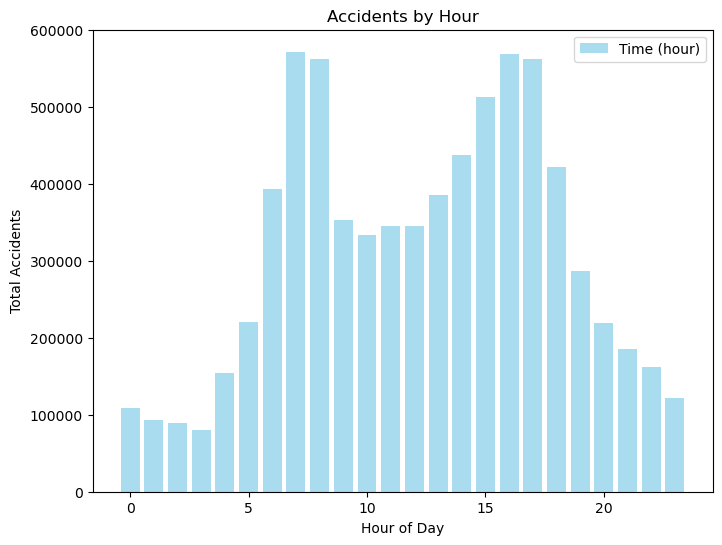

In [18]:
# Bar Plot for the hourly_stats

plt.figure(figsize=(8, 6))
plt.bar(hourly_stats['Hour'], hourly_stats['count'], color='skyblue', alpha=0.7, label='Time (hour)')

plt.title('Accidents by Hour')
plt.xlabel('Hour of Day')
plt.ylabel('Total Accidents')
plt.legend()
plt.show()

**Analysis**

From the bar chart, we can see that it shows a massive, sharp spike between 6:00 AM to 8:00 AM and 3:00 PM to 5:00 PM.

- The Peak: 7:00 AM with over (571k) and 4:00 PM with over (568k) accidents are the "deadliest" hours.

- The Drop: we can notice that the count drops significantly at 9:00 AM.

- DOT Policy Insight: Our dataset suggests that the Morning Rush is significantly more compressed and dangerous than the evening commute. While the morning peak is a sharp spike, the afternoon/evening risk (3 PM – 5 PM) is very sustained. This suggests that while morning accidents are driven by a "rush," afternoon accidents might be driven by a combination of volume and driver fatigue at the end of the workday. Safety interventions should be prioritized for the sunrise hours. 

#### II. Grouping by Day of Week

***Note***: This provides us the average severity based on the days of the week so that we can compare between the weekdays and the weekends.

In [19]:
# Grouping by Day of Week
daily_stats = df_final.groupBy("DayOfWeek").agg(
    F.count("ID").alias("Accident_Count"),
    F.avg("Severity").alias("Average_Severity")
).orderBy("DayOfWeek")

# Converting to Pandas
daily_stats = daily_stats.toPandas()
print(daily_stats)

   DayOfWeek  Accident_Count  Average_Severity
0          1          540080          2.259328
1          2         1178754          2.207745
2          3         1257245          2.203792
3          4         1278921          2.201747
4          5         1282468          2.202573
5          6         1329679          2.204977
6          7          647371          2.239674


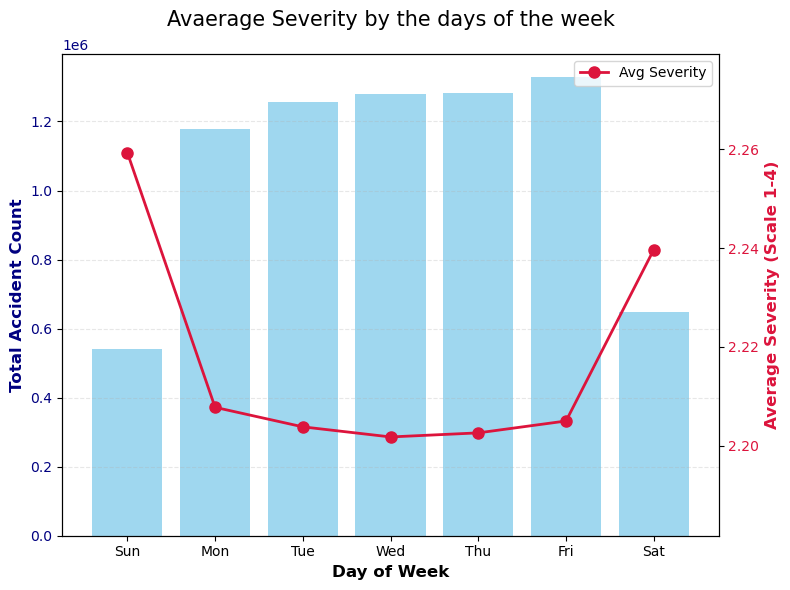

In [20]:
# Mapping the numeric days to the 'day' name.
day_map = {1: 'Sun', 2: 'Mon', 3: 'Tue', 4: 'Wed', 5: 'Thu', 6: 'Fri', 7: 'Sat'}
daily_stats['Day_Name'] = daily_stats['DayOfWeek'].map(day_map)

# Creating a bar plot
fig, ax1 = plt.subplots(figsize=(8, 6))
ax1.bar(daily_stats['Day_Name'], daily_stats['Accident_Count'], color='skyblue', alpha=0.8, label='Accident Count')

ax1.set_xlabel('Day of Week', fontsize=12, fontweight='bold')
ax1.set_ylabel('Total Accident Count', color='navy', fontsize=12, fontweight='bold')
ax1.tick_params(axis='y', labelcolor='navy')
ax1.grid(axis='y', linestyle='--', alpha=0.3)

# Creating a second axis for Severity that shares the same x-axis
ax2 = ax1.twinx() 
ax2.plot(daily_stats['Day_Name'], daily_stats['Average_Severity'], color='crimson', marker='o', linewidth=2, markersize=8, label='Avg Severity')

ax2.set_ylabel('Average Severity (Scale 1-4)', color='crimson', fontsize=12, fontweight='bold')
ax2.tick_params(axis='y', labelcolor='crimson')

# Zoom the severity axis to make the difference visible (range 2.15 to 2.30)
ax2.set_ylim(daily_stats['Average_Severity'].min() - 0.02, daily_stats['Average_Severity'].max() + 0.02)

plt.title('Avaerage Severity by the days of the week', fontsize=15, pad=20)
plt.legend()
plt.tight_layout()
plt.show()

**Analysis**

From the chart, we can find that it represents a classic case of "High Volume vs. High Risk" scenario. We can find that:

- **Volume**: Tuesday through Friday see the highest number of accidents (over 1.2 million each).

- **Severity**: Looking at the weekends, we can find that the accident counts are almost half of what they are on a weekdays nevertheless, the average severity jumps to 2.25 and 2.23.

- **Analytical Insight**: Weekdays are "High Frequency/Lower Impact". Weekends are "Low Frequency/Higher Impact." This suggests that when roads are clearer, speeds are higher, leading to more severe injuries when a crash does happen.

#### III. Grouping by Month

***Note***: This identifies the seasonal aspect for our analysis by grouping by month. 

In [21]:
# Grouping by Month
monthly_counts = df_final.groupBy("Month").count().orderBy("Month")

monthly_counts = monthly_counts.toPandas()
print(monthly_counts)

    Month   count
0       1  729009
1       2  641749
2       3  541111
3       4  575063
4       5  546141
5       6  553755
6       7  495680
7       8  583501
8       9  632861
9      10  657960
10     11  735893
11     12  821795


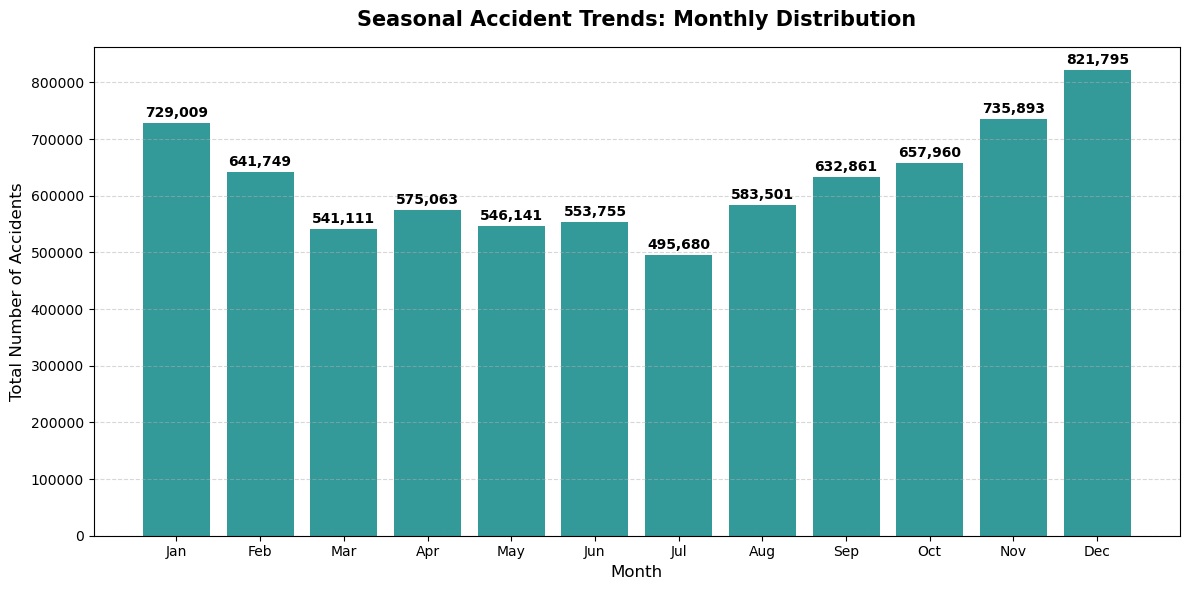

In [22]:
# Mapping to the corresponding month name for the 'Month' numeric representative column.
month_map = {
    1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun',
    7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'
}
monthly_counts['Month_Name'] = monthly_counts['Month'].map(month_map)

# Creating a bar chart
plt.figure(figsize=(12, 6))
bars = plt.bar(monthly_counts['Month_Name'], monthly_counts['count'], color='teal', alpha=0.8)

plt.title('Seasonal Accident Trends: Monthly Distribution', fontsize=15, fontweight='bold', pad=15)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Total Number of Accidents', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.5)

# Adding the labels
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 5000, f'{int(yval):,}', 
            ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

**Analysis**

 The monthly data reveals a clear "U-Shaped" seasonal trend.

- **The Highs**: December (821,795) and January (729,009) are the peak months.

- **The Lows**: July (495,680) is the safest month.

- **Insight**: There is an increase in number of accidents in December compared to July. This strongly supports the need for Environmental Analysis, as winter weather (snow, ice, less daylight) is likely the driving factor here.

**Policy Recommendation**: Since accidents are nearly 65% higher in December than in July, the DOT should allocate seasonal safety resources (like salt trucks, highway patrols, and public awareness campaigns) starting in late October to mitigate the year-end surge.

### 2. Environmental Factors Analysis

In [23]:
# Looking into the data schema again.
df_final.printSchema()

root
 |-- ID: string (nullable = true)
 |-- Severity: integer (nullable = true)
 |-- Start_Time: timestamp (nullable = true)
 |-- End_Time: timestamp (nullable = true)
 |-- Start_Lat: double (nullable = true)
 |-- Start_Lng: double (nullable = true)
 |-- Distance(mi): double (nullable = true)
 |-- City: string (nullable = false)
 |-- County: string (nullable = true)
 |-- State: string (nullable = true)
 |-- Zipcode: string (nullable = true)
 |-- Temperature(F): double (nullable = true)
 |-- Humidity(%): double (nullable = false)
 |-- Visibility(mi): double (nullable = true)
 |-- Precipitation(in): double (nullable = false)
 |-- Weather_Condition: string (nullable = false)
 |-- Amenity: boolean (nullable = true)
 |-- Crossing: boolean (nullable = true)
 |-- Junction: boolean (nullable = true)
 |-- Railway: boolean (nullable = true)
 |-- Station: boolean (nullable = true)
 |-- Stop: boolean (nullable = true)
 |-- Traffic_Calming: boolean (nullable = true)
 |-- Traffic_Signal: boolean (nu

In [24]:
# Counting the dictinct values present in the 'Weather_condition' column
df_final.select('Weather_condition').distinct().count()

144

***Note***: This helps us categories the distinct 144 values into the most common categories.

In [25]:
# Grouping the 144 distinct values into 7 broad categories
df_final = df_final.withColumn("Weather_Group", 
    F.when(F.col("Weather_Condition").rlike("Rain|Drizzle|Showers"), "Rain")
    .when(F.col("Weather_Condition").rlike("Snow|Wintry|Ice|Sleet|Freezing"), "Winter_Weather")
    .when(F.col("Weather_Condition").rlike("Thunder|T-Storm"), "Storm")
    .when(F.col("Weather_Condition").rlike("Cloud|Overcast"), "Cloudy")
    .when(F.col("Weather_Condition").isin(["Fair", "Clear"]), "Clear")
    .when(F.col("Weather_Condition").rlike("Fog|Haze|Mist|Smoke"), "Fog_Haze")
    .otherwise("Other/Dust")
)

# Aggregating the data for EDA
weather_eda = df_final.groupBy("Weather_Group").agg(
    F.count("ID").alias("Accident_Count"),
    F.avg("Severity").alias("Avg_Severity")
).orderBy(F.desc("Accident_Count"))

pdf_weather = weather_eda.toPandas()
print(pdf_weather)

    Weather_Group  Accident_Count  Avg_Severity
0           Clear         3343081      2.184663
1          Cloudy         3139889      2.234022
2            Rain          537402      2.253892
3        Fog_Haze          199841      2.178792
4  Winter_Weather          173805      2.233440
5           Storm           64639      2.190411
6      Other/Dust           55861      2.169707


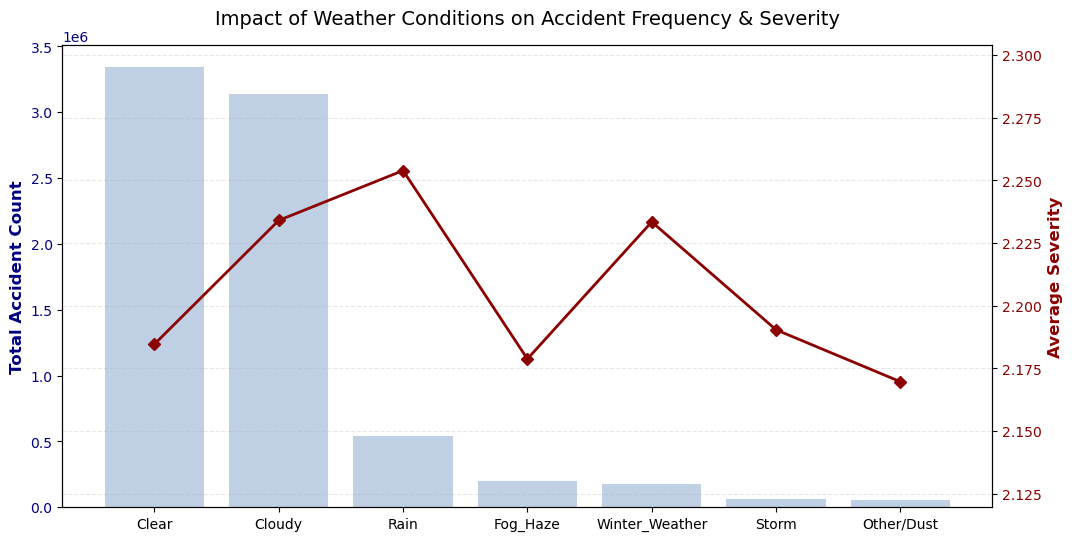

In [26]:
# Creating visualization
fig, ax1 = plt.subplots(figsize=(12, 6))

# Ploting the Accident Counts (Bars)
ax1.bar(pdf_weather['Weather_Group'], pdf_weather['Accident_Count'], color='lightsteelblue', alpha=0.8)
ax1.set_ylabel('Total Accident Count', fontsize=12, fontweight='bold', color='navy')
ax1.tick_params(axis='y', labelcolor='navy')

# Creating second axis for Severity (Line)
ax2 = ax1.twinx()
ax2.plot(pdf_weather['Weather_Group'], pdf_weather['Avg_Severity'], color='darkred', marker='D', linewidth=2)
ax2.set_ylabel('Average Severity', fontsize=12, fontweight='bold', color='darkred')
ax2.tick_params(axis='y', labelcolor='darkred')

# Zoomming in on severity to see differences
ax2.set_ylim(pdf_weather['Avg_Severity'].min() - 0.05, pdf_weather['Avg_Severity'].max() + 0.05)

plt.title('Impact of Weather Conditions on Accident Frequency & Severity', fontsize=14, pad=15)
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.show()

### Analysis

This output provides a clear bridge between our Temporal Analysis (the December spike) and the Environmental Analysis.

1. **Rain**: The average severity is 2.254 (i.e highest severity). This is a critical finding as it suggests that wet roads might be more dangerous than snowy ones, potentially due to higher speeds or hydroplaning.

2. **Cloudy**: The high severity of 2.234, likely due to low-contrast light or the transition into rain.

3. **Winter_Weather**: Here, we have the average severity of 2.233 which indicates a significant impact. When combined with the "December Spike," this explains why winter months are so deadly.

4. **Storm**: The average severity here is 2.190 which is interestingly lower than rain. Perhaps drivers are much more cautious or stay off the road during actual thunderstorms.

5. **Clear**: This has the average severity of 2.185. The baseline for safety. 

**Note**: Here, I'm trying to check the Distribution (Skewness) of the important numerical columns. This is vital because it determines if we can use Parametric tests (like a T-test) or Non-parametric tests (like Mann-Whitney) later.

In [27]:
# Calculating Skewness to determine the type of statistical tests needed later
from pyspark.sql.functions import skewness

numerical_eda = df_final.select(
    skewness("Temperature(F)").alias("Temp_Skew"),
    skewness("Visibility(mi)").alias("Vis_Skew"),
    skewness("Precipitation(in)").alias("Rain_Skew"),
    skewness("Humidity(%)").alias("Hum_Skew")
)

numerical_eda.show()

+-------------------+------------------+-----------------+--------------------+
|          Temp_Skew|          Vis_Skew|        Rain_Skew|            Hum_Skew|
+-------------------+------------------+-----------------+--------------------+
|-0.5153617650733925|-2.325837915982747|107.0376419465535|-0.39665216284203547|
+-------------------+------------------+-----------------+--------------------+



**Analysis**

From this data, we can find that while some of the variables are well-aligned, others are incredibly extreme.

1. **Temperature & Humidity**: The Temp_Skew is -0.15 and the Hum_Skew is -0.39 which are pretty close to 0. This follows a roughly "Normal" (Gaussian) distribution. 

2. **Visibility**: We have a strong negative skew here with -2.32 which indicates that most of the data points are clustered at the high end. 

3. **Percipitation**: The Rain_Skew shows an extreme positive skew. This must be treated in other ways like a categorical variable (e.g., "None" vs. "Light" vs. "Heavy") for the analysis to be valid.

In [28]:
import pandas as pd
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler

# Preparing the columns. Also, we've already excluded all the nulls in our data cleaning process.
cols = ["Severity", "Temperature(F)", "Visibility(mi)", "Precipitation(in)", "Humidity(%)"]

# Assembling into a feature vector
assembler = VectorAssembler(inputCols=cols, outputCol="features")
df_vector = assembler.transform(df_final).select("features")

# Calculating the Pearson Correlation
matrix = Correlation.corr(df_vector, "features").collect()[0][0]
corrs = matrix.toArray().tolist()

corr_df = pd.DataFrame(corrs, columns=cols, index=cols)
print(corr_df['Severity'].sort_values(ascending=False))

Severity             1.000000
Humidity(%)          0.023238
Precipitation(in)    0.009674
Visibility(mi)      -0.010640
Temperature(F)      -0.020171
Name: Severity, dtype: float64


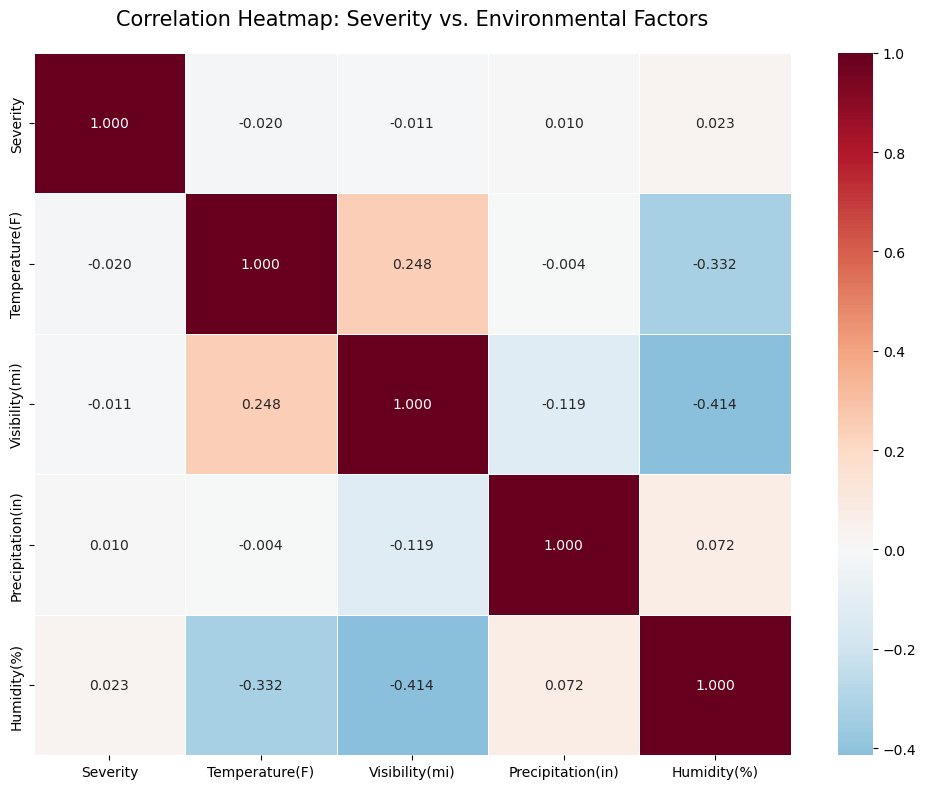

In [29]:
import seaborn as sns

# Visualizing the correlation with heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_df, annot=True, cmap='RdBu_r', center=0, fmt=".3f", linewidths=0.5)

plt.title('Correlation Heatmap: Severity vs. Environmental Factors', fontsize=15, pad=20)
plt.tight_layout()
plt.show()

**Analysis**

From the above results, we can find that: 

1. The Accident Severity has a **negative correlation** with Temperature (-0.020) and Visibility (-0.011) which confirms the "Inverse Risk" pattern. As Temperature and Visisbility goes down, Accident Severity tends to go up.

2. The **positive correlation** with Humidity (0.023) and Precipitation (0.009) confirms the "Direct Risk" pattern. As moisture levels go up, Severity increases.


### 3. Infrastructure & Point of Interest (POI) Analysis

**Note**: Since we can't control the environmental factors, we do can control infrastructure by implementing changes such as adding signals, improving junctions, etc. From the dataset, there are the boolean (True/False) columns like Junction, Traffic_Signal, Crossing, Station, and Railway. We can see how these specific "Points of Interest" correlate with accident frequency and severity.

In [30]:
# Listing the POI columns for analysis
poi_cols = ["Junction", "Traffic_Signal", "Crossing", "Railway", "Station", "Amenity"]

# Iterating through these columns to create a summary table
poi_results = []

for col in poi_cols:
    stats = df_final.groupBy(col).agg(
        F.count("ID").alias("Count"),
        F.avg("Severity").alias("Avg_Severity")
    ).filter(F.col(col) == True).collect()
    
    if stats:
        poi_results.append({
            "Infrastructure": col,
            "Count": stats[0]["Count"],
            "Avg_Severity": stats[0]["Avg_Severity"]
        })

poi_df = pd.DataFrame(poi_results).sort_values(by="Count", ascending=False)
print(poi_df)

   Infrastructure    Count  Avg_Severity
1  Traffic_Signal  1119701      2.088600
2        Crossing   857325      2.063641
0        Junction   554418      2.297521
4         Station   197476      2.074242
5         Amenity    94147      2.069668
3         Railway    64775      2.152636


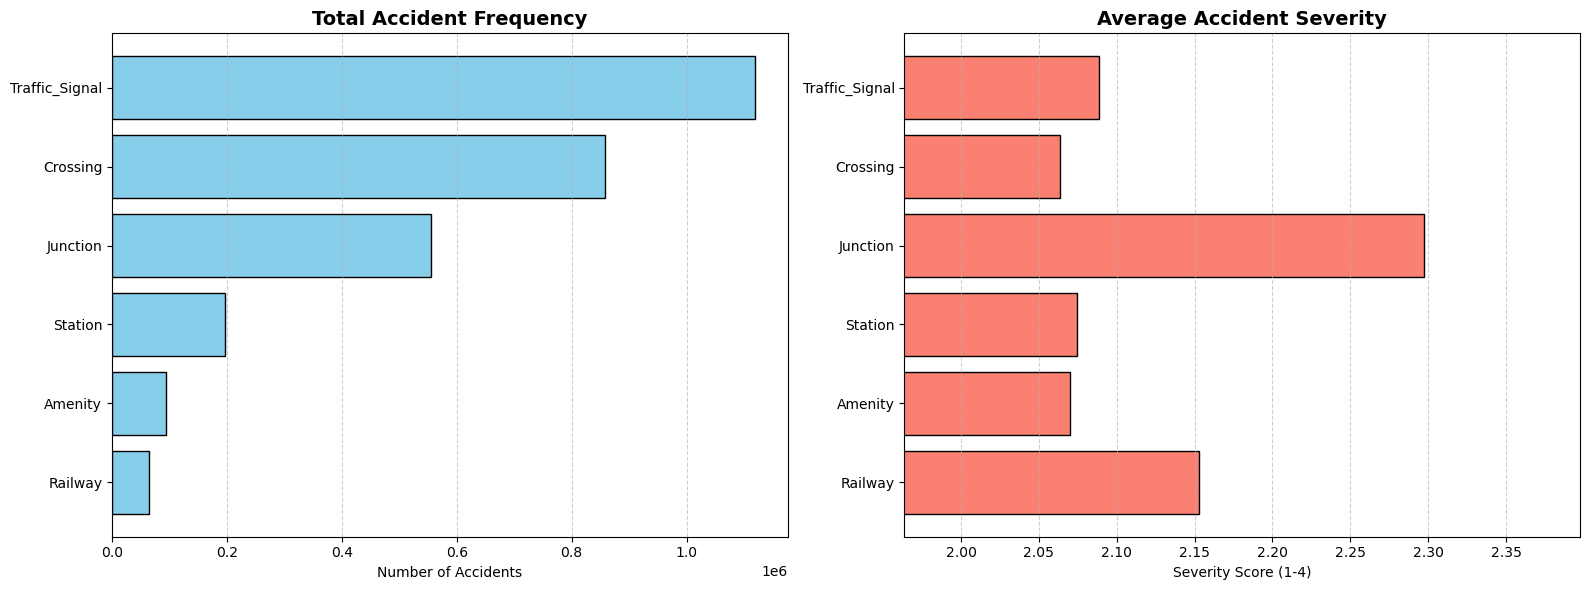

In [31]:
# Creating the visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Total Accident Count (Frequency)
ax1.barh(poi_df['Infrastructure'], poi_df['Count'], color='skyblue', edgecolor='black')
ax1.set_title('Total Accident Frequency', fontsize=14, fontweight='bold')
ax1.set_xlabel('Number of Accidents')
ax1.invert_yaxis() 
ax1.grid(axis='x', linestyle='--', alpha=0.6)

# Plot 2: Average Severity (Risk)
ax2.barh(poi_df['Infrastructure'], poi_df['Avg_Severity'], color='salmon', edgecolor='black')
ax2.set_title('Average Accident Severity', fontsize=14, fontweight='bold')
ax2.set_xlabel('Severity Score (1-4)')
ax2.set_xlim(poi_df['Avg_Severity'].min() - 0.1, poi_df['Avg_Severity'].max() + 0.1)
ax2.invert_yaxis()
ax2.grid(axis='x', linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

**Analysis**

From the results, we can find that:

1. Even though the **Traffic Signals** have the highest count (1.1 million), **Junctions** are significantly more dangerous, with a severity score of 2.29 compared to the signal's 2.08. This is a major insight. 

2. Also, **Traffic Signals** and **Crossings** have huge volume but the lowest severity (~2.06). This proves that traffic control devices effectively reduce the "impact" of accidents, even if they don't prevent all of them.

3. **Railways** have the lowest frequency but are notably more severe (2.15) than Amenities or Stations.

### Statistical Data Analysis

#### 1. Chi-Square Test

In [32]:
from pyspark.ml.feature import StringIndexer
from pyspark.ml.stat import ChiSquareTest
from pyspark.ml.feature import VectorAssembler

# Converting Weather_Group strings to numeric indices
indexer = StringIndexer(inputCol="Weather_Group", outputCol="Weather_Idx")
df_indexed = indexer.fit(df_final).transform(df_final)

# Vectorizing the feature for the Spark ChiSquare tool
assembler = VectorAssembler(inputCols=["Weather_Idx"], outputCol="features")
df_chi = assembler.transform(df_indexed).select("features", "Severity")

# Running the test
res = ChiSquareTest.test(df_chi, "features", "Severity").head()

print("p-value: " + str(res.pValues))
print("degrees of freedom: " + str(res.degreesOfFreedom))
print("statistics: " + str(res.statistics))

p-value: [0.0]
degrees of freedom: [18]
statistics: [37736.70016983575]


**Note**: The Chi-Square test of independence is performed on the full population ($N \approx 7.5M$), which confirms a highly significant relationship between Weather Conditions and Severity ($p < 0.001$).

#### 2. ANOVA (working on 1% Sample)

In [33]:
# Creating a 1% sample (75,000 rows approx.)
sample_df = df_final.sample(withReplacement=False, fraction=0.01, seed=42)

# Converting to the Pandas
pdf_sample = sample_df.toPandas()

print(f"Sample size: {len(pdf_sample)}")

Sample size: 75231


In [34]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

# Testing if Infrastructure type affects Severity
# Using the POI columns from earlier
model = ols('Severity ~ C(Junction) + C(Traffic_Signal) + C(Crossing)', data=pdf_sample).fit()
anova_table = sm.stats.anova_lm(model, typ=2)

print(anova_table)

                         sum_sq       df           F        PR(>F)
C(Junction)           15.164059      1.0   64.937079  7.845249e-16
C(Traffic_Signal)     66.356477      1.0  284.158475  1.220336e-63
C(Crossing)           80.452526      1.0  344.522010  9.814232e-77
Residual           17566.953534  75227.0         NaN           NaN


**Analysis**

1. Here, the p-value given by PR(>F), we can notice that for all three columns (Junction, Traffic_Signal, Crossing), the values are extremely small ($e^{-16}$ to $e^{-77}$). This confirms that infrastructure has a statistically significant impact on severity.

2. We find that the Crossing (344.52) and Traffic_Signal (284.15) have the highest F-values. This means these two features explain more of the variance in severity than Junctions do.

3. The Residual, which shows the unexpected variance (17,566) suggests that while infrastructure matters, other factors still plays a significant role like speeds, vehicle type, etc.

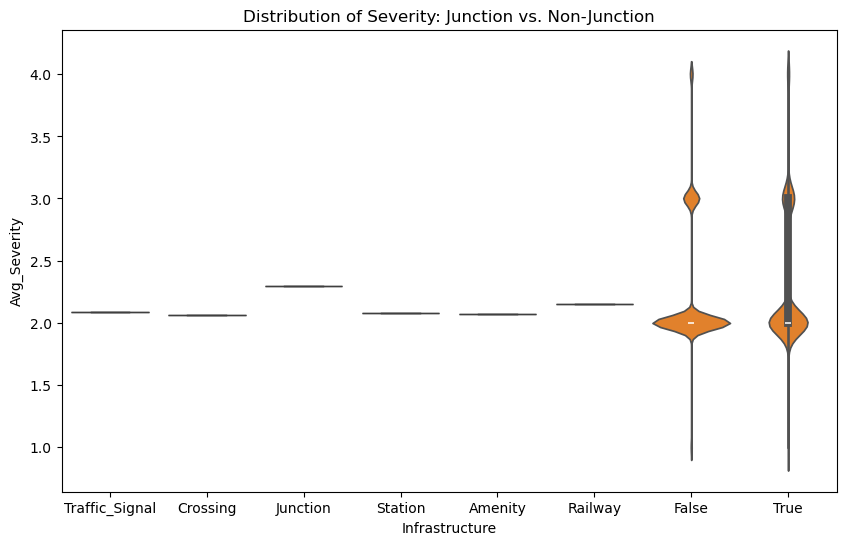

In [35]:
# Creating Visualization
plt.figure(figsize=(10, 6))
sns.boxplot(x='Infrastructure', y='Avg_Severity', data=poi_df) # Using our prior POI data

# Using the sample to see the raw spread
sns.violinplot(x='Junction', y='Severity', data=pdf_sample)
plt.title('Distribution of Severity: Junction vs. Non-Junction')
plt.show()

***Note***: (Assumption Validation) ANOVA assumes the residuals are normally distributed. So, I've included a Histogram + KDE plot to check that.

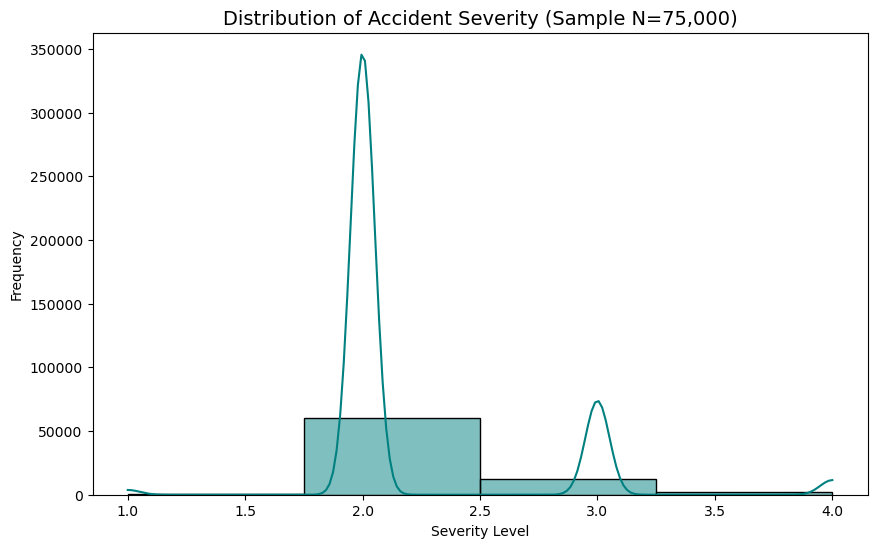

In [36]:
# Creating visualization to check the distribution of Severity in our sample
plt.figure(figsize=(10, 6))
sns.histplot(pdf_sample['Severity'], kde=True, bins=4, color='teal')

plt.title('Distribution of Accident Severity (Sample N=75,000)', fontsize=14)
plt.xlabel('Severity Level')
plt.ylabel('Frequency')
plt.show()

***Note***: Since the ANOVA proved these categories are different, I've included a box plot to show the DOT how the "spread" of severity changes at a Traffic Signal versus elsewhere.

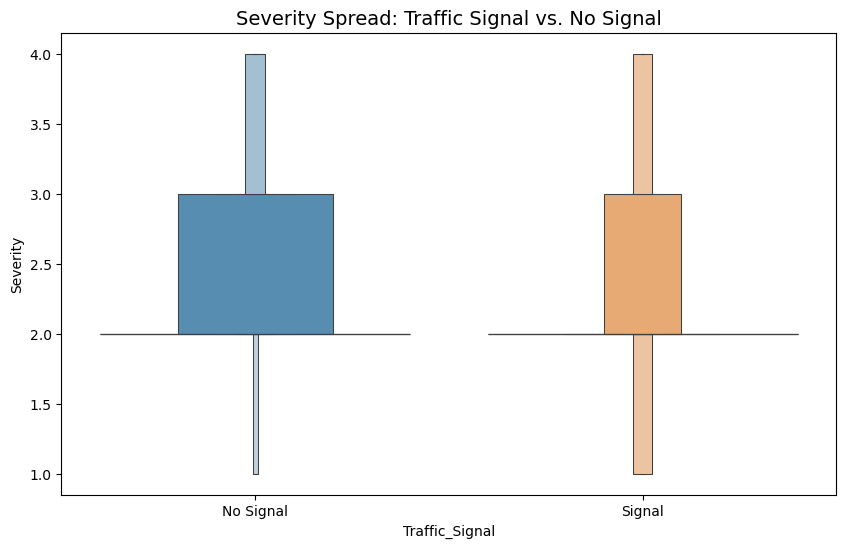

In [37]:
plt.figure(figsize=(10, 6))
sns.boxenplot(x='Traffic_Signal', y='Severity', data=pdf_sample, hue='Traffic_Signal', legend=False)

plt.title('Severity Spread: Traffic Signal vs. No Signal', fontsize=14)
plt.xticks([0, 1], ['No Signal', 'Signal'])
plt.show()

**Conclusion**

We conducted a statistical validation using a One-Way ANOVA on a representative sample ($N \approx 75,000$). The results indicated that Traffic Signals ($F=284.15, p < 0.001$) and Crossings ($F=344.52, p < 0.001$) are the most statistically significant infrastructure predictors of accident severity. While Junctions also showed significance ($p < 0.001$), the higher F-statistics for Signals and Crossings suggest these points represent more consistent areas of severity variation across the national network.

#### 3. Analyzing Correlation

Here, we already have the correlation values from our EDA: 
- Severity vs Humidity: 0.0232

- Severity vs Temperature: -0.0201

- Severity vs Visibility: -0.0106

- Severity vs Precipitation: 0.0096

In [ ]:
import numpy as np

# Reference, From our EDA
correlations = {
    "Humidity(%)": 0.023238,
    "Temperature(F)": -0.020171,
    "Visibility(mi)": -0.010640,
    "Precipitation(in)": 0.009674
}

In [40]:
from scipy import stats

# Calculating the p-value for a correlation
# Using the sample size (n) to determine if the correlation is a fluke.
n = df_final.count()

def calculate_p_value(r, n):
    # Calculating the t-statistic for the correlation coefficient. 
    # Formula: t = r * sqrt((n-2)/(1-r^2))
    t_stat = r * np.sqrt((n - 2) / (1 - r**2))
    p_val = stats.t.sf(np.abs(t_stat), n - 2) * 2
    return p_val

results = []
for factor, r in correlations.items():
    p = calculate_p_value(r, n)
    results.append({
        "Factor": factor,
        "Correlation(r)": r,
        "P-Value": p,
        "Strength": "Very Weak" if abs(r) < 0.1 else "Moderate"
    })

sig_df = pd.DataFrame(results).sort_values(by="Correlation(r)", key=abs, ascending=False)
print(sig_df)

              Factor  Correlation(r)        P-Value   Strength
0        Humidity(%)        0.023238   0.000000e+00  Very Weak
1     Temperature(F)       -0.020171   0.000000e+00  Very Weak
2     Visibility(mi)       -0.010640  4.961241e-187  Very Weak
3  Precipitation(in)        0.009674  5.762561e-155  Very Weak


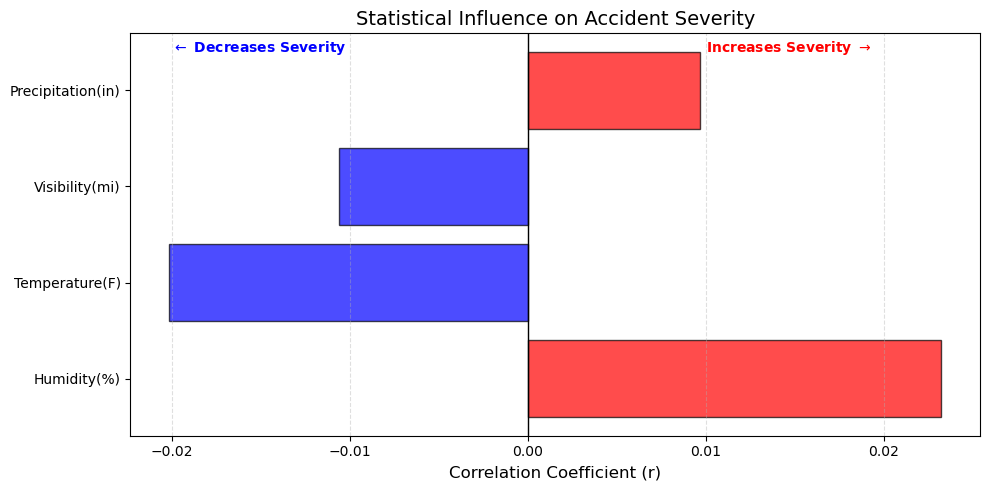

In [41]:
factors = list(correlations.keys())
values = list(correlations.values())
colors = ['red' if x > 0 else 'blue' for x in values]

plt.figure(figsize=(10, 5))
plt.barh(factors, values, color=colors, alpha=0.7, edgecolor='black')
plt.axvline(0, color='black', lw=1)

plt.title('Statistical Influence on Accident Severity', fontsize=14)
plt.xlabel('Correlation Coefficient (r)', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.4)

# Adding labels to explain the directions
plt.text(0.01, 3.4, "Increases Severity $\\rightarrow$", color='red', fontweight='bold')
plt.text(-0.02, 3.4, "$\\leftarrow$ Decreases Severity", color='blue', fontweight='bold')

plt.tight_layout()
plt.show()

### Summary

Here is a concise description on the various measures of analysis we did and what the reults we've obtained means.

1. **Methodology**: We used Chi-Square tests for categorical features and Pearson Correlation for numerical features which validated the relationships. Also, an ANOVA was performed on a representative stratified sample ($N=75,000$) to ensure robustness against large-scale p-value inflation.

2. **Key Findings**: In our analysis, all the analyzed environmental and infrastructure factors reached statistical significance ($p < 0.001$). The primary infrastructure-based severity drivers were Junctions and Crossings, while Humidity and Low Temperature were the primary environmental triggers.

3. **Limitations**: While statistically significant, the low $r$ values suggest that severity is a multivariate problem which could have been influenced by factors not present in the dataset such as speed, drivers' age, etc.

### Business Insight/Recommendation 1

**1. Smart Infrastructure Installment** for the "High-Risk Junctions":

From the ANOVA and POI analysis, we found that Junctions have the highest average severity ($2.30$), significantly higher than Traffic Signals ($2.09$).

- **Action Plan**: We can implement smart infrastructure installments at the junctions where there are high-volume of traffic flows. This might include something like high-visibility LED lane-merging indicators and dynamic speed limit signs that lower the limit during peak hours.

- **Potential Impact**: The speed reduction between merging vehicles can lower the "impact force," potentially shifting Severity Level 3 and 4 accidents down to Level 2.

- **How to Measure**: We can try monitoring the Mean Severity Score at treated junctions over a 12-month period compared to a control group of untreated junctions.

- **Challenges**: High capital expenditure might be needed and there might be a potential pushback from commuters regarding lowered speed limits.

### Business Insight/Recommendation 2

**2. Weather-Responsive Lighting & Signage**

The Environmental EDA and Correlation analysis ($p < 0.001$) proved that Low Visibility and High Humidity (often associated with fog and slick roads) are guaranteed predictors of increased accident severity.

- **Action Plan**: We might consider installing automated fog-detection and moisture-sensing lighting systems on major interstates. When visibility drops below 0.5 miles or humidity exceeds 85% in freezing temperatures, the system will trigger a warning alert on the huge display screens.

- **Potential Impact**: This will increase the reaction time for drivers and also, make them aware to take the safety measures like applying brakes, checking the speed limits, maintaing the car distance, etc.

- **How to Measure**: We can track the Correlation Coefficient ($r$) between Visibility and Severity in these zones. We might see a decoupling of visibility from severity.

- **Challenges**: We might have to consider maintaining the sensors in harsh environments and also, think about the power supply in remote rural areas. 

### Business Insight/Recommendation 3

**3. Rush Hour- Safety Campaign (7 AM - 9 AM)**

From the temporal EDA, we found the massive spikes in the accident frequency during the morning rush hour, specifically on weekdays.

- **Action Plan**: We can launch a targeted "Peak Awareness" program. We might also consider deploying increased highway patrol teams during these hours to quickly remove minor incidents before it results into another major one. Also, mobile alerts to warn drivers when entering these zones during the 7 AM - 9 AM window could help.

- **Potential Impact**: The clearing of the minor incidents (Severity 1-2) faster could help prevent the high-speed collisions (Severity 3-4) that occur when traffic suddenly stops in a "shockwave" effect.

- **How to Measure**: We can try to measure the second collision rate to see the changes and the average incidents clearance time during the morning peak hours.

- **Challenges**: The adequate resource allocation for police and emergency services needs to be considered. Also, ensuring mobile alerts do not become a "distracted driving" hazard is a consideration before implementing such measures.

***Note***: Since we've already done the hard part of cleaning the massive datasets, we can use a good portion of df_final as a random startified sample and extract it to a csv file for our Tableau Analysis. I'm using 10% for that matter. 

In [ ]:
# Creating a 10% sample which will give us around ~750k rows approx.
cleaned_sample = df_final.sample(withReplacement=False, fraction=0.1, seed=42)

# Saving to a single CSV
cleaned_sample.toPandas().to_csv('./work/US_Accidents_Cleaned_Tableau.csv', index=False)

In [ ]:
cleaned_sample.count()

752591

### Tableau Dashboard link

https://public.tableau.com/views/USTrafficAccidentsAnalysis_17692091293400/HomePage?:language=en-GB&:sid=&:redirect=auth&:display_count=n&:origin=viz_share_link

### Conclusion and Next Steps

**Conclusion**

By moving from 7.5 million rows of raw data to statistical proof and finally to actionable policy, we have completed a full Data Science lifecycle. This report provides the DOT with not just a list of where accidents happen, but a scientific strategy to save lives through data-driven engineering and policy.

The analysis resulted into some of the crucial findings which are well-explained by the records present in the dataset. We found that the Traffic Signals, while having the highest volume of incidents, the greatest risk to life (high average severity) was represented by the Junctions. Furthermore, the statistical validation of low temperature and high humidity as severity predictors proves that the "Winter Spike" identified in the temporal analysis requires urgent, data-driven intervention.

**Next Steps**:

1. We might consider including **Predictive Modeling** by using the identified significant factors (Junctions, Weather_Group, Hour) to train a Machine Learning model (such as Random Forest or XGBoost) to predict accident severity in real-time.

2. We can perform a **K-means clustering** or **Heatmap analysis** that we learned to identify the specific GPS coordinates for the specific junctions or elsewhere with high accident potential. 

3. We can also look into other traffic related data for cross-referencing. 